In [ ]:
# !pip install sklearn-evaluation

In [1]:
# !conda install -y catboost tensorflow

In [154]:
import os

from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from catboost.utils import get_confusion_matrix
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
import shap
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn_evaluation import plot
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from scikeras.wrappers import KerasClassifier
import xgboost as xgb

In [3]:
np.set_printoptions(suppress=True)

In [4]:
with psycopg2.connect(user='daan', password=os.environ['JUPYTER_TOKEN'], host='pg', port=5432, dbname='phishing_data') as cx:
    data = pd.read_sql_query('select * from full_dataset', cx)

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


In [5]:
constant_features = [data.columns.get_loc(x) for x in data.nunique()[(data.nunique()==1)].index.to_list()]

In [6]:
constant_feature_names = data.columns[constant_features].to_list()

In [7]:
# drop features that are constant
data.drop(constant_feature_names, axis=1, inplace=True)

In [8]:
data.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,2,0,0,...,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,...,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,...,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3597,0,1,0,0,0,0


In [9]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.phishing, random_state=42)

In [10]:
cat_features = [X_train.columns.get_loc(x) for x in X_train.nunique()[(X_train.nunique()<3)].index.to_list()]

## Logistic Regression

In [11]:
model_results = []

In [12]:
cat_feature_names = X_train.columns[cat_features]
numeric_feature_names = X_train.columns.difference(cat_feature_names)

In [13]:
numeric_transformer = MinMaxScaler()
cat_transformer = OneHotEncoder(handle_unknown='infrequent_if_exist')

transform = ColumnTransformer(transformers=[
    ('numeric', numeric_transformer, [X_train.columns.get_loc(x) for x in numeric_feature_names]),
    ('categorical', cat_transformer, [X_train.columns.get_loc(x) for x in cat_feature_names])
])

In [14]:
pipe = Pipeline(steps=[
    ('transform', transform),
    ('predict', LogisticRegression(C=10, max_iter=1000, n_jobs=-1, solver='sag')) 
])

In [15]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  [86, 44, 96, 24, 85, 62, 18,
                                                   80, 34, 52, 70, 7, 40, 58,
                                                   76, 13, 33, 51, 69, 6, 38,
                                                   56, 74, 11, 42, 78, 15, 27,
                                                   19, 45, ...]),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  [22, 25, 26, 31, 41, 48, 49,
                                                   59, 60, 77, 83, 93, 97])])),
                ('predict',
                 LogisticRegression(C=10, max_iter=1000, n_jobs=-1,
                                    solver='sag'))])

In [16]:
train_pred = pipe.predict(X_train)

In [17]:
test_pred = pipe.predict(X_test)

In [18]:
print(classification_report(train_pred, y_train))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     42842
           1       0.92      0.89      0.90     23643

    accuracy                           0.93     66485
   macro avg       0.93      0.92      0.93     66485
weighted avg       0.93      0.93      0.93     66485



In [19]:
print(classification_report(test_pred, y_test))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     14270
           1       0.91      0.89      0.90      7892

    accuracy                           0.93     22162
   macro avg       0.93      0.92      0.92     22162
weighted avg       0.93      0.93      0.93     22162



In [20]:
model_results.append({'model': 'LR_baseline', 
                      'accuracy_train': accuracy_score(train_pred, y_train), 
                      'accuracy_test': accuracy_score(test_pred, y_test), 
                      'f1_train': f1_score(train_pred, y_train), 
                      'f1_test': f1_score(test_pred, y_test), 
                      'roc_auc_train': roc_auc_score(train_pred, y_train), 
                      'roc_auc_test': roc_auc_score(test_pred, y_test)})

### Grid Search

In [21]:
# https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
scoring = ['accuracy', 'f1', 'roc_auc']

param_grid = {'C': np.logspace(-3, 2, 6)}

pipe = Pipeline(steps=[
    ('transform', transform),
    ('predict', GridSearchCV(LogisticRegression(max_iter=1000, n_jobs=-1, solver='sag'), param_grid, return_train_score=True, refit='f1', scoring=scoring, n_jobs=-1))
])

In [22]:
pipe.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
The max_iter was reached which means the coef_ did not converge


Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  [86, 44, 96, 24, 85, 62, 18,
                                                   80, 34, 52, 70, 7, 40, 58,
                                                   76, 13, 33, 51, 69, 6, 38,
                                                   56, 74, 11, 42, 78, 15, 27,
                                                   19, 45, ...]),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  [22, 25, 26, 31, 41, 48, 49,
                                                   59, 60, 77, 83, 93, 97])])),
                ('predict',
                 GridSearchCV(estimator=LogisticRegression(max_iter=1000,
                                                           n_jobs=-1,
                                                           solver='sag'),
                              n_jobs=-1,
                              param_grid={'C': array([  0.001,   0.01 ,   0.1  ,   1.   ,  10.   , 100.   ])},
                              refit='f1', return_train_score=True,
                              scoring=['accuracy', 'f1', 'roc_auc']))])

In [23]:
pipe.named_steps['predict'].best_params_

{'C': 100.0}

In [24]:
pipe.named_steps['predict'].cv_results_

{'mean_fit_time': array([ 1.31012883,  1.3596808 ,  2.26372848,  7.45094047, 20.44119792,
        92.38158793]),
 'std_fit_time': array([0.06684   , 0.10852883, 0.09893925, 0.35873783, 0.9167036 ,
        1.46201912]),
 'mean_score_time': array([0.01384759, 0.01238008, 0.01447659, 0.01348357, 0.01283059,
        0.01135259]),
 'std_score_time': array([0.00077069, 0.00051438, 0.00236425, 0.00130433, 0.00109378,
        0.00072936]),
 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1.0},
  {'C': 10.0},
  {'C': 100.0}],
 'split0_test_accuracy': array([0.86026923, 0.89065203, 0.91110777, 0.92276453, 0.9269008 ,
        0.92893134]),
 'split1_test_accuracy': array([0.86184854, 0.89373543, 0.91546965, 0.92675039, 0.93058585,
        0.93111228]),
 'split2_test_accuracy': array([0.86034444, 0.892532

In [25]:
train_pred = pipe.predict(X_train)

In [26]:
test_pred = pipe.predict(X_test)

In [27]:
print(classification_report(train_pred, y_train))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     43041
           1       0.91      0.90      0.91     23444

    accuracy                           0.93     66485
   macro avg       0.93      0.93      0.93     66485
weighted avg       0.93      0.93      0.93     66485



In [28]:
print(classification_report(test_pred, y_test))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     14337
           1       0.91      0.89      0.90      7825

    accuracy                           0.93     22162
   macro avg       0.93      0.92      0.92     22162
weighted avg       0.93      0.93      0.93     22162



In [29]:
model_results.append({'model': 'LR_grid', 
                      'accuracy_train': accuracy_score(train_pred, y_train), 
                      'accuracy_test': accuracy_score(test_pred, y_test), 
                      'f1_train': f1_score(train_pred, y_train), 
                      'f1_test': f1_score(test_pred, y_test), 
                      'roc_auc_train': roc_auc_score(train_pred, y_train), 
                      'roc_auc_test': roc_auc_score(test_pred, y_test)})

### LR with PCA

In [30]:
pca_pipe = Pipeline(steps=[
    ('transform', transform),
    ('pca', PCA()),
    ('predict', LogisticRegression(C=10, max_iter=1000, n_jobs=-1, solver='sag')) 
])

In [31]:
pca_pipe.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  [86, 44, 96, 24, 85, 62, 18,
                                                   80, 34, 52, 70, 7, 40, 58,
                                                   76, 13, 33, 51, 69, 6, 38,
                                                   56, 74, 11, 42, 78, 15, 27,
                                                   19, 45, ...]),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  [22, 25, 26, 31, 41, 48, 49,
                                                   59, 60, 77, 83, 93, 97])])),
                ('pca', PCA()),
                ('predict',
                 LogisticRegression(C=10, max_iter=1000, n_jobs=-1,
                                    solver='sag'))])

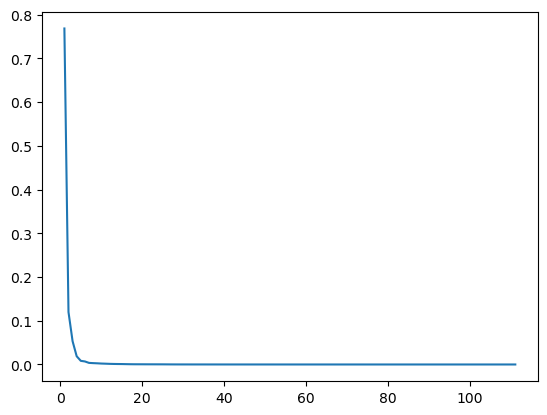

In [32]:
plt.plot((np.arange(pca_pipe.named_steps['pca'].n_components_) + 1), pca_pipe.named_steps['pca'].explained_variance_ratio_)

In [33]:
pca_pipe.named_steps['pca'].explained_variance_ratio_

array([0.76843227, 0.11987717, 0.05316217, 0.01878635, 0.00832194,
       0.00692803, 0.00365641, 0.00309916, 0.00268204, 0.00213609,
       0.00181465, 0.00144764, 0.00121476, 0.00105146, 0.00097274,
       0.00077251, 0.00060153, 0.00049256, 0.00046566, 0.00043191,
       0.00038564, 0.0003632 , 0.00034675, 0.00032576, 0.00030166,
       0.0002401 , 0.00017585, 0.00013337, 0.00011455, 0.00009964,
       0.00009714, 0.00008212, 0.00008143, 0.00007949, 0.0000763 ,
       0.00006357, 0.0000584 , 0.00004952, 0.00004568, 0.00003814,
       0.00003687, 0.00003517, 0.00003214, 0.00003162, 0.00002948,
       0.00002745, 0.00002658, 0.00002566, 0.00002356, 0.00002129,
       0.00001959, 0.00001788, 0.00001747, 0.00001423, 0.00001372,
       0.00001319, 0.00001252, 0.00001163, 0.00000982, 0.00000946,
       0.00000911, 0.00000723, 0.00000701, 0.00000525, 0.00000481,
       0.00000443, 0.00000407, 0.00000363, 0.00000349, 0.00000325,
       0.00000253, 0.00000229, 0.00000194, 0.00000119, 0.00000

In [34]:
pca_pipe = Pipeline(steps=[
    ('transform', transform),
    ('pca', PCA(n_components=3)),
    ('predict', LogisticRegression(C=10, max_iter=1000, n_jobs=-1, solver='sag')) 
])

In [35]:
pca_pipe.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  [86, 44, 96, 24, 85, 62, 18,
                                                   80, 34, 52, 70, 7, 40, 58,
                                                   76, 13, 33, 51, 69, 6, 38,
                                                   56, 74, 11, 42, 78, 15, 27,
                                                   19, 45, ...]),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  [22, 25, 26, 31, 41, 48, 49,
                                                   59, 60, 77, 83, 93, 97])])),
                ('pca', PCA(n_components=3)),
                ('predict',
                 LogisticRegression(C=10, max_iter=1000, n_jobs=-1,
                                    solver='sag'))])

In [36]:
train_pred_pca = pca_pipe.predict(X_train)

In [37]:
test_pred_pca = pca_pipe.predict(X_test)

In [38]:
print(classification_report(train_pred_pca, y_train))

              precision    recall  f1-score   support

           0       0.80      0.98      0.89     35552
           1       0.98      0.72      0.83     30933

    accuracy                           0.86     66485
   macro avg       0.89      0.85      0.86     66485
weighted avg       0.88      0.86      0.86     66485



In [39]:
print(classification_report(test_pred_pca, y_test))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89     11957
           1       0.98      0.73      0.84     10205

    accuracy                           0.87     22162
   macro avg       0.89      0.86      0.86     22162
weighted avg       0.89      0.87      0.87     22162



In [40]:
model_results.append({'model': 'LR_pca_baseline', 
                      'accuracy_train': accuracy_score(train_pred_pca, y_train), 
                      'accuracy_test': accuracy_score(test_pred_pca, y_test), 
                      'f1_train': f1_score(train_pred_pca, y_train), 
                      'f1_test': f1_score(test_pred_pca, y_test), 
                      'roc_auc_train': roc_auc_score(train_pred_pca, y_train), 
                      'roc_auc_test': roc_auc_score(test_pred_pca, y_test)})

### Grid Search

In [41]:
pca_pipe = Pipeline(steps=[
    ('transform', transform),
    ('pca', PCA(n_components=3)),
    ('predict', GridSearchCV(LogisticRegression(max_iter=1000, n_jobs=-1, solver='sag'), param_grid, return_train_score=True, refit='f1', scoring=scoring, n_jobs=-1)) 
])

In [42]:
pca_pipe.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  [86, 44, 96, 24, 85, 62, 18,
                                                   80, 34, 52, 70, 7, 40, 58,
                                                   76, 13, 33, 51, 69, 6, 38,
                                                   56, 74, 11, 42, 78, 15, 27,
                                                   19, 45, ...]),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  [22, 25, 26, 31, 41, 48, 49,
                                                   59, 60, 77, 83, 93, 97])])),
                ('pca', PCA(n_components=3)),
                ('predict',
                 GridSearchCV(estimator=LogisticRegression(max_iter=1000,
                                                           n_jobs=-1,
                                                           solver='sag'),
                              n_jobs=-1,
                              param_grid={'C': array([  0.001,   0.01 ,   0.1  ,   1.   ,  10.   , 100.   ])},
                              refit='f1', return_train_score=True,
                              scoring=['accuracy', 'f1', 'roc_auc']))])

In [43]:
pca_pipe.named_steps['predict'].best_params_

{'C': 0.001}

In [44]:
pca_pipe.named_steps['predict'].cv_results_

{'mean_fit_time': array([0.17603464, 0.18174772, 0.26027846, 0.3722569 , 0.43677869,
        0.34630747]),
 'std_fit_time': array([0.00798657, 0.01026557, 0.02221607, 0.04779491, 0.05707606,
        0.06284498]),
 'mean_score_time': array([0.00913305, 0.0129117 , 0.00943971, 0.01052794, 0.00900273,
        0.00878186]),
 'std_score_time': array([0.00047882, 0.00717411, 0.00065757, 0.00176878, 0.00062735,
        0.00106726]),
 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1.0},
  {'C': 10.0},
  {'C': 100.0}],
 'split0_test_accuracy': array([0.86026923, 0.86026923, 0.86026923, 0.86026923, 0.86026923,
        0.86026923]),
 'split1_test_accuracy': array([0.86184854, 0.86184854, 0.86184854, 0.86184854, 0.86184854,
        0.86184854]),
 'split2_test_accuracy': array([0.86034444, 0.86034444, 0.

In [45]:
train_pred_pca = pca_pipe.predict(X_train)

In [46]:
test_pred_pca = pca_pipe.predict(X_test)

In [47]:
print(classification_report(train_pred_pca, y_train))

              precision    recall  f1-score   support

           0       0.80      0.98      0.89     35552
           1       0.98      0.72      0.83     30933

    accuracy                           0.86     66485
   macro avg       0.89      0.85      0.86     66485
weighted avg       0.88      0.86      0.86     66485



In [48]:
print(classification_report(test_pred_pca, y_test))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89     11957
           1       0.98      0.73      0.84     10205

    accuracy                           0.87     22162
   macro avg       0.89      0.86      0.86     22162
weighted avg       0.89      0.87      0.87     22162



In [49]:
model_results.append({'model': 'LR_pca_grid', 
                      'accuracy_train': accuracy_score(train_pred_pca, y_train), 
                      'accuracy_test': accuracy_score(test_pred_pca, y_test), 
                      'f1_train': f1_score(train_pred_pca, y_train), 
                      'f1_test': f1_score(test_pred_pca, y_test), 
                      'roc_auc_train': roc_auc_score(train_pred_pca, y_train), 
                      'roc_auc_test': roc_auc_score(test_pred_pca, y_test)})

## XGBoost

In [50]:
# https://xgboost.readthedocs.io/en/stable/python/python_intro.html
clf = xgb.XGBClassifier(tree_method='hist', enable_categorical=True, max_cat_to_onehot=3)

In [51]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=3,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [52]:
train_pred_xgb = clf.predict(X_train)

In [53]:
test_pred_xgb = clf.predict(X_test)

In [54]:
print(classification_report(train_pred_xgb, y_train))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     43597
           1       0.97      0.98      0.97     22888

    accuracy                           0.98     66485
   macro avg       0.98      0.98      0.98     66485
weighted avg       0.98      0.98      0.98     66485



In [55]:
print(classification_report(test_pred_xgb, y_test))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     14467
           1       0.96      0.95      0.95      7695

    accuracy                           0.97     22162
   macro avg       0.97      0.96      0.96     22162
weighted avg       0.97      0.97      0.97     22162



In [56]:
clf.predict_proba(X_test.sample(1))

array([[0.97256494, 0.02743507]], dtype=float32)

In [57]:
clf.predict_proba(X_test.sample(10))

array([[0.99366266, 0.00633736],
       [0.96345866, 0.03654133],
       [0.9997305 , 0.0002695 ],
       [0.9993644 , 0.00063562],
       [0.9999398 , 0.00006019],
       [0.0718447 , 0.9281553 ],
       [0.0029406 , 0.9970594 ],
       [0.9996121 , 0.0003879 ],
       [0.9999945 , 0.00000546],
       [0.99982446, 0.00017553]], dtype=float32)

In [58]:
clf.save_model('../models/xgb.json')

In [59]:
model_results.append({'model': 'xgb_baseline', 
                      'accuracy_train': accuracy_score(train_pred_xgb, y_train), 
                      'accuracy_test': accuracy_score(test_pred_xgb, y_test), 
                      'f1_train': f1_score(train_pred_xgb, y_train), 
                      'f1_test': f1_score(test_pred_xgb, y_test), 
                      'roc_auc_train': roc_auc_score(train_pred_xgb, y_train), 
                      'roc_auc_test': roc_auc_score(test_pred_xgb, y_test)})

### Grid Search

In [60]:
param_grid = {'learning_rate': [1e-2, 5e-2, 1e-1], 'max_depth': [4, 6, 8], 'n_estimators': [100, 500, 1000]}

In [61]:
xgb_grid = GridSearchCV(xgb.XGBClassifier(tree_method='hist', enable_categorical=True, max_cat_to_onehot=3), param_grid, return_train_score=True, refit='f1', scoring=scoring, n_jobs=-1)

In [62]:
xgb_grid.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_o...
                                     min_child_weight=None, missing=nan,
                                     monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [4, 6, 8],
                         'n_estimators': [100, 500, 1000]},
             refit='f1', return_train_score=True,
             scoring=['accuracy', 'f1', 'roc_auc'])

In [63]:
xgb_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 1000}

In [64]:
xgb_grid.cv_results_ 

{'mean_fit_time': array([ 4.43395925, 18.71354361, 31.67998281,  4.51721749, 23.48211231,
        42.59958367,  5.22756076, 28.07863936, 46.95035405,  4.10786114,
        14.18894434, 27.06058979,  4.90895782, 16.29699836, 31.11575785,
         5.42477293, 19.51092882, 40.4005578 ,  3.65248618, 13.71021914,
        25.77232194,  4.15565619, 15.82839789, 33.32996755,  4.73963675,
        20.22909169, 39.62595062]),
 'std_fit_time': array([0.29728166, 0.76339853, 1.08072737, 0.240052  , 0.99321603,
        1.82302095, 0.18725216, 0.65745236, 1.37386635, 0.15229935,
        0.33913056, 0.72242913, 0.27490869, 0.34578977, 0.68728676,
        0.17582997, 0.29415701, 1.37168447, 0.17557922, 0.56196279,
        0.67151295, 0.13398548, 0.17655975, 0.93833432, 0.07433785,
        0.69738263, 0.54913402]),
 'mean_score_time': array([0.08920894, 0.2038898 , 0.37523527, 0.10814543, 0.4183229 ,
        0.89394689, 0.13407187, 0.62185807, 1.09448023, 0.09135842,
        0.22217388, 0.3569993 , 0.110

In [65]:
train_pred_xgb = xgb_grid.predict(X_train)

In [66]:
test_pred_xgb = xgb_grid.predict(X_test)

In [67]:
print(classification_report(train_pred_xgb, y_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     43514
           1       1.00      1.00      1.00     22971

    accuracy                           1.00     66485
   macro avg       1.00      1.00      1.00     66485
weighted avg       1.00      1.00      1.00     66485



In [68]:
print(classification_report(test_pred_xgb, y_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     14474
           1       0.96      0.96      0.96      7688

    accuracy                           0.97     22162
   macro avg       0.97      0.97      0.97     22162
weighted avg       0.97      0.97      0.97     22162



In [69]:
model_results.append({'model': 'xgb_grid', 
                      'accuracy_train': accuracy_score(train_pred_xgb, y_train), 
                      'accuracy_test': accuracy_score(test_pred_xgb, y_test), 
                      'f1_train': f1_score(train_pred_xgb, y_train), 
                      'f1_test': f1_score(test_pred_xgb, y_test), 
                      'roc_auc_train': roc_auc_score(train_pred_xgb, y_train), 
                      'roc_auc_test': roc_auc_score(test_pred_xgb, y_test)})

## CatBoost

In [70]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [71]:
catboost_model = CatBoostClassifier(iterations=250,
                                    depth=10,
                                    learning_rate=1e-1,
                                    eval_metric='F1'
                                   )

In [72]:
catboost_model.fit(train_pool)

0:	learn: 0.8949237	total: 111ms	remaining: 27.7s
1:	learn: 0.9038120	total: 168ms	remaining: 20.9s
2:	learn: 0.9143085	total: 233ms	remaining: 19.2s
3:	learn: 0.9192387	total: 288ms	remaining: 17.7s
4:	learn: 0.9205643	total: 344ms	remaining: 16.8s
5:	learn: 0.9250478	total: 399ms	remaining: 16.2s
6:	learn: 0.9266708	total: 493ms	remaining: 17.1s
7:	learn: 0.9280310	total: 556ms	remaining: 16.8s
8:	learn: 0.9288752	total: 622ms	remaining: 16.7s
9:	learn: 0.9309655	total: 678ms	remaining: 16.3s
10:	learn: 0.9324348	total: 737ms	remaining: 16s
11:	learn: 0.9328625	total: 797ms	remaining: 15.8s
12:	learn: 0.9332528	total: 850ms	remaining: 15.5s
13:	learn: 0.9344283	total: 910ms	remaining: 15.3s
14:	learn: 0.9352325	total: 963ms	remaining: 15.1s
15:	learn: 0.9357556	total: 1.01s	remaining: 14.8s
16:	learn: 0.9365847	total: 1.07s	remaining: 14.7s
17:	learn: 0.9372732	total: 1.13s	remaining: 14.5s
18:	learn: 0.9373191	total: 1.18s	remaining: 14.4s
19:	learn: 0.9384183	total: 1.24s	remaining

In [73]:
train_pred_cb = catboost_model.predict(train_pool)

In [74]:
test_pred_cb = catboost_model.predict(test_pool)

In [75]:
print(classification_report(train_pred_cb, y_train))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     43633
           1       0.98      0.98      0.98     22852

    accuracy                           0.99     66485
   macro avg       0.98      0.99      0.99     66485
weighted avg       0.99      0.99      0.99     66485



In [76]:
print(classification_report(test_pred_cb, y_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     14478
           1       0.96      0.96      0.96      7684

    accuracy                           0.97     22162
   macro avg       0.97      0.97      0.97     22162
weighted avg       0.97      0.97      0.97     22162



In [77]:
model_results.append({'model': 'cb_baseline', 
                      'accuracy_train': accuracy_score(train_pred_cb, y_train), 
                      'accuracy_test': accuracy_score(test_pred_cb, y_test), 
                      'f1_train': f1_score(train_pred_cb, y_train), 
                      'f1_test': f1_score(test_pred_cb, y_test), 
                      'roc_auc_train': roc_auc_score(train_pred_cb, y_train), 
                      'roc_auc_test': roc_auc_score(test_pred_cb, y_test)})

### Grid Search

In [78]:
param_grid = {'iterations': [200, 250, 300], 'depth': [6, 8, 10], 'learning_rate': [1e-2, 5e-2, 1e-1]}

In [79]:
# https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier_grid_search
cb_grid_model = CatBoostClassifier(eval_metric='F1', logging_level='Silent')
cb_grid_result = cb_grid_model.grid_search(param_grid, train_pool)

0:	loss: 0.9167483	best: 0.9167483 (0)	total: 2.55s	remaining: 1m 6s
1:	loss: 0.9377178	best: 0.9377178 (1)	total: 4.86s	remaining: 1m
2:	loss: 0.9439354	best: 0.9439354 (2)	total: 7.08s	remaining: 56.7s
3:	loss: 0.9207211	best: 0.9439354 (2)	total: 10.2s	remaining: 58.4s
4:	loss: 0.9409586	best: 0.9439354 (2)	total: 13s	remaining: 57.1s
5:	loss: 0.9458397	best: 0.9458397 (5)	total: 15.8s	remaining: 55.3s
6:	loss: 0.9237113	best: 0.9458397 (5)	total: 19.5s	remaining: 55.9s
7:	loss: 0.9421253	best: 0.9458397 (5)	total: 23s	remaining: 54.6s
8:	loss: 0.9476097	best: 0.9476097 (8)	total: 26.7s	remaining: 53.4s
9:	loss: 0.9277187	best: 0.9476097 (8)	total: 30.6s	remaining: 52.1s
10:	loss: 0.9459548	best: 0.9476097 (8)	total: 34.2s	remaining: 49.8s
11:	loss: 0.9510061	best: 0.9510061 (11)	total: 37.7s	remaining: 47.1s
12:	loss: 0.9305556	best: 0.9510061 (11)	total: 42.2s	remaining: 45.5s
13:	loss: 0.9477815	best: 0.9510061 (11)	total: 46.6s	remaining: 43.3s
14:	loss: 0.9526103	best: 0.952610

In [80]:
cb_grid_result['params']

{'depth': 10, 'iterations': 300, 'learning_rate': 0.1}

In [81]:
train_pred_cb = cb_grid_model.predict(train_pool)

In [82]:
test_pred_cb = cb_grid_model.predict(test_pool)

In [83]:
print(classification_report(train_pred_cb, y_train))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     43650
           1       0.98      0.99      0.98     22835

    accuracy                           0.99     66485
   macro avg       0.99      0.99      0.99     66485
weighted avg       0.99      0.99      0.99     66485



In [84]:
print(classification_report(test_pred_cb, y_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     14488
           1       0.96      0.96      0.96      7674

    accuracy                           0.97     22162
   macro avg       0.97      0.97      0.97     22162
weighted avg       0.97      0.97      0.97     22162



In [85]:
model_results.append({'model': 'cb_grid', 
                      'accuracy_train': accuracy_score(train_pred_cb, y_train), 
                      'accuracy_test': accuracy_score(test_pred_cb, y_test), 
                      'f1_train': f1_score(train_pred_cb, y_train), 
                      'f1_test': f1_score(test_pred_cb, y_test), 
                      'roc_auc_train': roc_auc_score(train_pred_cb, y_train), 
                      'roc_auc_test': roc_auc_score(test_pred_cb, y_test)})

## Neural Network

In [86]:
# https://gist.github.com/MaxHalford/9bfaa8daf8b4bc17a7fb7ba58c880675
input_dim = len(pipe.named_steps['transform'].get_feature_names_out())
def nn_model():
    model = tf.keras.models.Sequential([
        Dense(128, input_dim=input_dim, activation='relu'),
        # Dropout(0.2),
        Dense(64, activation='relu'),
        # Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=
                  ['accuracy', 'AUC'])
    
    return model

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks
logdir = os.path.join("tensorboard", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cb = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [87]:
nn_pipe = Pipeline(steps=[
    ('transform', transform),
    ('predict', KerasClassifier(model=nn_model, batch_size=32, epochs=100,
                               validation_split=0.2, callbacks=[early_stopping, tensorboard_cb])) 
])

In [88]:
nn_pipe

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  [86, 44, 96, 24, 85, 62, 18,
                                                   80, 34, 52, 70, 7, 40, 58,
                                                   76, 13, 33, 51, 69, 6, 38,
                                                   56, 74, 11, 42, 78, 15, 27,
                                                   19, 45, ...]),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  [22, 25, 26, 31, 41, 48, 49,
                                                   59, 60, 77, 83, 93, 97])])),
                ('predict',
                 KerasClassifier(batch_size=32, callbacks=[<keras.callbacks.EarlyStopping object at 0x7fe688e25f30>, <keras.callbacks.TensorBoard object at 0x7fe688e271c0>], epochs=100, model=<function nn_model at 0x7fe688e9e3b0>, validation_split=0.2))])

In [89]:
# https://www.adriangb.com/scikeras/stable/migration.html#migration
history = nn_pipe.fit(X_train, y_train)

2022-10-18 14:01:37.152096: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
1663/1663 [==============================] - 4s 2ms/step - loss: 0.2141 - accuracy: 0.9106 - auc: 0.9680 - val_loss: 0.2188 - val_accuracy: 0.9128 - val_auc: 0.9803
Epoch 2/100
1663/1663 [==============================] - 3s 2ms/step - loss: 0.1820 - accuracy: 0.9253 - auc: 0.9773 - val_loss: 0.1680 - val_accuracy: 0.9305 - val_auc: 0.9825
Epoch 3/100
1663/1663 [==============================] - 3s 2ms/step - loss: 0.1747 - accuracy: 0.9278 - auc: 0.9791 - val_loss: 0.1550 - val_accuracy: 0.9370 - val_auc: 0.9841
Epoch 4/100
1663/1663 [==============================] - 3s 2ms/step - loss: 0.1666 - accuracy: 0.9310 - auc: 0.9810 - val_loss: 0.1621 - val_accuracy: 0.9305 - val_auc: 0.9847
Epoch 5/100
1663/1663 [==============================] - 3s 2ms/step - loss: 0.1603 - accuracy: 0.9323 - auc: 0.9824 - val_loss: 0.1420 - val_accuracy: 0.9418 - val_auc: 0.9866
Epoch 6/100
1663/1663 [==============================] - 3s 2ms/step - loss: 0.1513 - accuracy: 0.9388 - auc: 0.984

In [90]:
train_pred_nn = nn_pipe.predict(X_train)

2078/2078 [==============================] - 2s 793us/step


In [91]:
test_pred_nn = nn_pipe.predict(X_test)

693/693 [==============================] - 1s 796us/step


In [92]:
print(classification_report(train_pred_nn, y_train))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     43398
           1       0.93      0.93      0.93     23087

    accuracy                           0.95     66485
   macro avg       0.95      0.94      0.95     66485
weighted avg       0.95      0.95      0.95     66485



In [93]:
print(classification_report(test_pred_nn, y_test))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     14471
           1       0.93      0.92      0.92      7691

    accuracy                           0.95     22162
   macro avg       0.94      0.94      0.94     22162
weighted avg       0.95      0.95      0.95     22162



In [94]:
model_results.append({'model': 'nn_baseline', 
                      'accuracy_train': accuracy_score(train_pred_nn, y_train), 
                      'accuracy_test': accuracy_score(test_pred_nn, y_test), 
                      'f1_train': f1_score(train_pred_nn, y_train), 
                      'f1_test': f1_score(test_pred_nn, y_test), 
                      'roc_auc_train': roc_auc_score(train_pred_nn, y_train), 
                      'roc_auc_test': roc_auc_score(test_pred_nn, y_test)})

In [95]:
history = nn_pipe.named_steps['predict'].history_

In [96]:
%load_ext tensorboard

In [97]:
%tensorboard --logdir=tensorboard/ --port 6006 --bind_all

### Grid Search

In [98]:
# clear session/graph
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()

In [99]:
# https://www.adriangb.com/scikeras/stable/quickstart.html#in-an-sklearn-pipeline
# tensorboard callback doesn't work, maybe due to similar issue: https://github.com/keras-team/keras-tuner/issues/574
param_grid = {'optimizer__learning_rate': [1e-3, 1e-2, 1e-1], 'batch_size': [16, 32, 64]}
nn_pipe = Pipeline(steps=[
    ('transform', transform),
    ('predict', GridSearchCV(KerasClassifier(model=nn_model, epochs=100, validation_split=0.2, callbacks=[early_stopping], verbose=0), param_grid, return_train_score=True, refit='f1', scoring=scoring, n_jobs=-1))
     ])

In [100]:
nn_pipe.fit(X_train, y_train)

INFO:tensorflow:Assets written to: ram:///tmp/tmpo4cmalv8/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpj4hqi2o4/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp2i10b0vd/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpcesgudan/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpqc0yiwyx/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp7a37c760/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpd566wgxu/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpck934dg_/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp10pfkhf9/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpffis1yio/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp1d0irs6b/assets


2022-10-18 14:02:30.140652: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: ram:///tmp/tmpuctdhcfr/assets


2022-10-18 14:02:31.281582: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: ram:///tmp/tmpuvp4oz2u/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmphp8uzgeh/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpc8j_sxat/assets


2022-10-18 14:02:33.100976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: ram:///tmp/tmpc_99vga0/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpggj9s1b2/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpmi04u6uq/assets


2022-10-18 14:02:34.843650: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: ram:///tmp/tmp0qnz0u3z/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp5y7hw8lb/assets


2022-10-18 14:02:36.458125: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 14:02:38.245839: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: ram:///tmp/tmp8vugqtw5/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp5xwqkqc8/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpmit31dqa/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp48q11tod/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpqg1o2s9i/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpiaz_22ne/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpwr_pbrte/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpc_ct6w1l/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpjgjgr_yr/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmph5o8pmhq/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpivw8ihjc/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpz8nul1mo/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmppeka36wc/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpke6s_cme/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpqghxit02/assets
INFO:tensorflow:Assets wr

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  [86, 44, 96, 24, 85, 62, 18,
                                                   80, 34, 52, 70, 7, 40, 58,
                                                   76, 13, 33, 51, 69, 6, 38,
                                                   56, 74, 11, 42, 78, 15, 27,
                                                   19, 45, ...]),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  [22, 25, 26, 31, 41, 48, 49,
                                                   59, 60, 77, 83, 93, 97])])),
                ('predict',
                 GridSearchCV(estimator=KerasClassifier(callbacks=[<keras.callbacks.EarlyStopping object at 0x7fe688e25f30>], epochs=100, model=<function nn_model at 0x7fe688e9e3b0>, validation_split=0.2, verbose=0),
                              n_jobs=-1,
                              param_grid={'batch_size': [16, 32, 64],
                                          'optimizer__learning_rate': [0.001,
                                                                       0.01,
                                                                       0.1]},
                              refit='f1', return_train_score=True,
                              scoring=['accuracy', 'f1', 'roc_auc']))])

In [101]:
nn_pipe.named_steps['predict'].best_params_

{'batch_size': 64, 'optimizer__learning_rate': 0.01}

In [102]:
train_pred_nn = nn_pipe.predict(X_train)

In [103]:
test_pred_nn = nn_pipe.predict(X_test)

In [104]:
print(classification_report(train_pred_nn, y_train))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     43368
           1       0.93      0.93      0.93     23117

    accuracy                           0.95     66485
   macro avg       0.95      0.94      0.95     66485
weighted avg       0.95      0.95      0.95     66485



In [105]:
print(classification_report(test_pred_nn, y_test))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     14428
           1       0.93      0.92      0.92      7734

    accuracy                           0.95     22162
   macro avg       0.94      0.94      0.94     22162
weighted avg       0.95      0.95      0.95     22162



In [106]:
model_results.append({'model': 'nn_grid', 
                      'accuracy_train': accuracy_score(train_pred_nn, y_train), 
                      'accuracy_test': accuracy_score(test_pred_nn, y_test), 
                      'f1_train': f1_score(train_pred_nn, y_train), 
                      'f1_test': f1_score(test_pred_nn, y_test), 
                      'roc_auc_train': roc_auc_score(train_pred_nn, y_train), 
                      'roc_auc_test': roc_auc_score(test_pred_nn, y_test)})

## Analysis

In [107]:
results_df = pd.DataFrame(model_results)

In [108]:
results_df

,model,accuracy_train,accuracy_test,f1_train,f1_test,roc_auc_train,roc_auc_test
0,LR_baseline,0.932707,0.930512,0.904041,0.901016,0.923448,0.921037
1,LR_grid,0.933805,0.931459,0.905202,0.901943,0.925258,0.922675
2,LR_pca_baseline,0.863488,0.868739,0.831658,0.837222,0.854476,0.858800
3,LR_pca_grid,0.863488,0.868739,0.831658,0.837222,0.854476,0.858800
4,xgb_baseline,0.982688,0.968189,0.974907,0.954105,0.981310,0.964472
5,xgb_grid,0.999789,0.972836,0.999695,0.960792,0.999819,0.969691
6,cb_baseline,0.986719,0.970129,0.980734,0.956873,0.985953,0.966756
7,cb_grid,0.988810,0.970490,0.983761,0.957366,0.988356,0.967287
8,nn_baseline,0.950214,0.947342,0.928150,0.924009,0.944552,0.941524
9,nn_grid,0.950184,0.947478,0.928153,0.924416,0.944403,0.941185


In [168]:
results_df.to_csv()

',model,accuracy_train,accuracy_test,f1_train,f1_test,roc_auc_train,roc_auc_test\n0,LR_baseline,0.9327066255546363,0.930511686670878,0.9040408373369938,0.9010155546985473,0.9234476446449559,0.9210369508334485\n1,LR_grid,0.9338046175829134,0.9314592545799115,0.9052019386106622,0.9019430637144149,0.9252581789532675,0.9226749127182934\n2,LR_pca_baseline,0.8634880048131157,0.8687392834581716,0.8316578254256779,0.837222315483185,0.854476067151376,0.8587999575647458\n3,LR_pca_grid,0.8634880048131157,0.8687392834581716,0.8316578254256779,0.837222315483185,0.854476067151376,0.8587999575647458\n4,xgb_baseline,0.9826878243212754,0.9681887916253046,0.9749067997994288,0.9541045504849945,0.9813102076085854,0.9644715878439574\n5,xgb_grid,0.9997894261863578,0.9728363866077069,0.9996953342618383,0.9607919760323043,0.9998185801923382,0.9696906735921902\n6,cb_baseline,0.9867188087538542,0.9701290497247541,0.9807344053411298,0.9568729641693811,0.9859529054116704,0.9667557857084353\n7,cb_grid,0.9888095059

In [109]:
results_df.model.loc[results_df.accuracy_test.idxmax()]

'xgb_grid'

In [110]:
results_df.model.loc[results_df.f1_test.idxmax()]

'xgb_grid'

In [111]:
results_df.model.loc[results_df.roc_auc_test.idxmax()]

'xgb_grid'

#### Logistic Regression

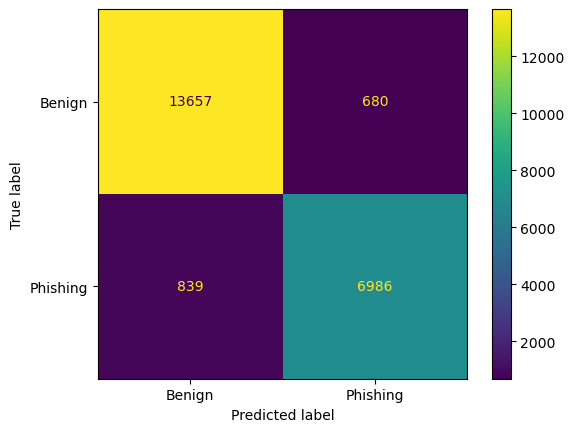

In [115]:
cm = ConfusionMatrixDisplay(confusion_matrix(test_pred, y_test), display_labels=['Benign', 'Phishing'])
cm.plot()

<AxesSubplot:title={'center':'ROC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

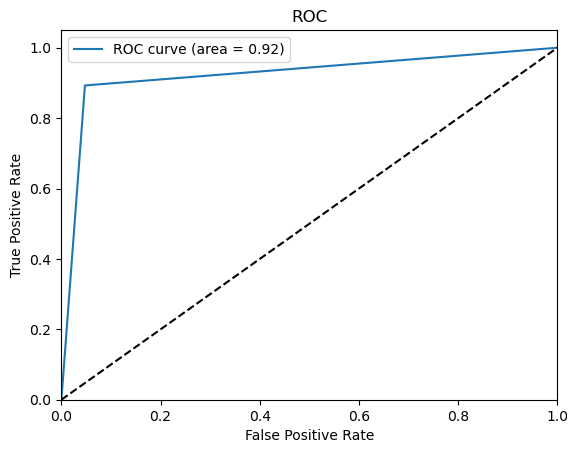

In [158]:
# https://sklearn-evaluation.readthedocs.io/en/latest/user_guide/classifier.html
plot.roc(test_pred, y_test)

#### LR with PCA

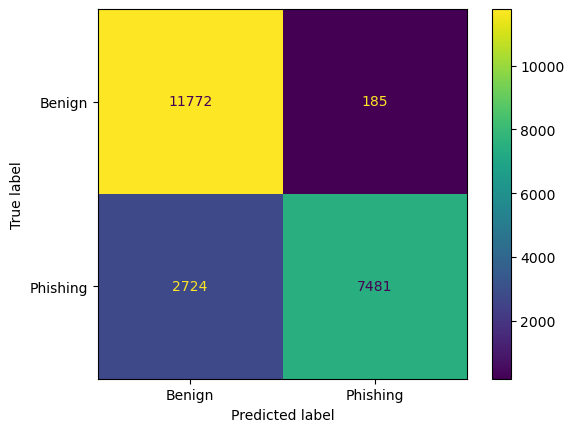

In [116]:
cm = ConfusionMatrixDisplay(confusion_matrix(test_pred_pca, y_test), display_labels=['Benign', 'Phishing'])
cm.plot()

<AxesSubplot:title={'center':'ROC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

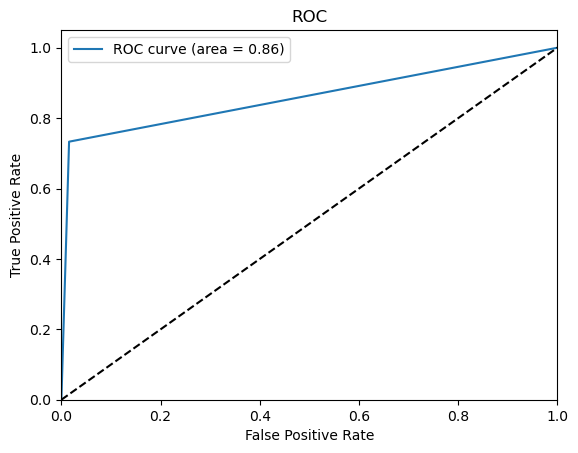

In [159]:
plot.roc(test_pred_pca, y_test)

#### XGBoost

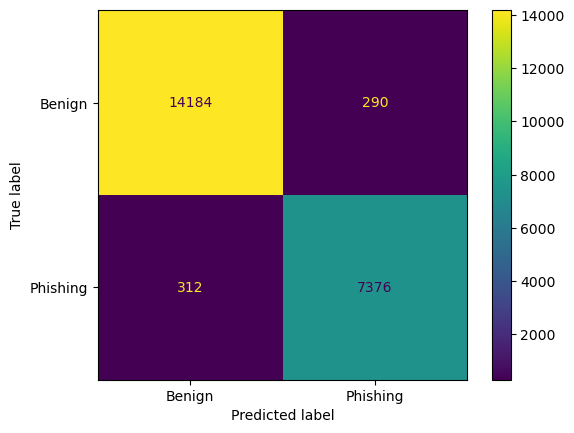

In [117]:
cm = ConfusionMatrixDisplay(confusion_matrix(test_pred_xgb, y_test), display_labels=['Benign', 'Phishing'])
cm.plot()

In [ ]:
plt.plot(cb_grid_model.get_evals_result()['learn']['Logloss'], label='Logloss')
plt.plot(cb_grid_model.get_evals_result()['learn']['F1'], label='F1')
plt.legend()

<AxesSubplot:title={'center':'ROC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

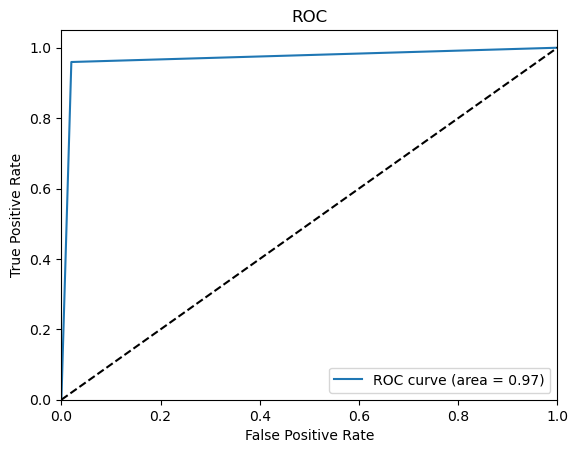

In [152]:
plot.roc(test_pred_xgb, y_test)

#### CatBoost

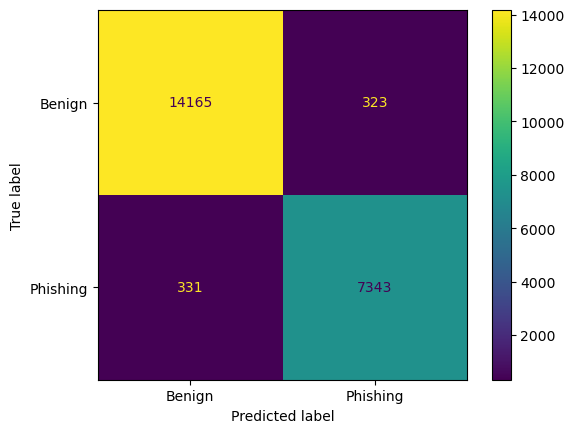

In [118]:
cm = ConfusionMatrixDisplay(confusion_matrix(test_pred_cb, y_test), display_labels=['Benign', 'Phishing'])
cm.plot()

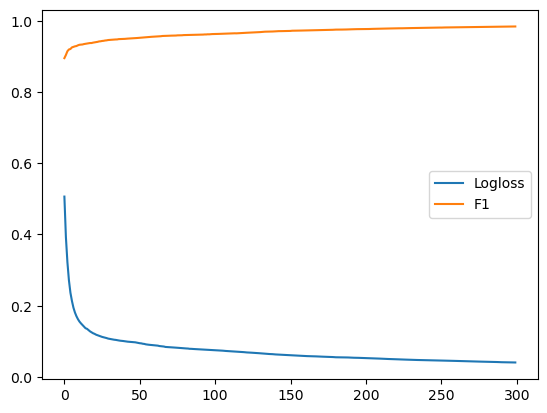

In [135]:
plt.plot(cb_grid_model.get_evals_result()['learn']['Logloss'], label='Logloss')
plt.plot(cb_grid_model.get_evals_result()['learn']['F1'], label='F1')
plt.legend()

<AxesSubplot:title={'center':'ROC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

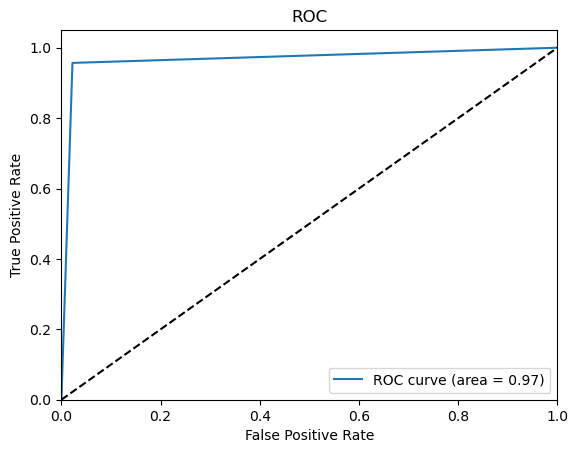

In [155]:
plot.roc(test_pred_cb, y_test)

#### Neural Network

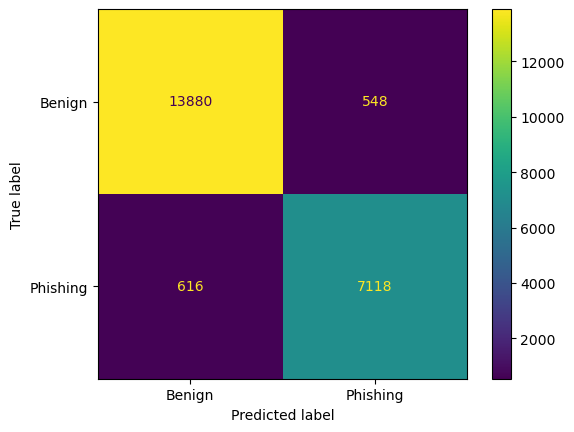

In [119]:
cm = ConfusionMatrixDisplay(confusion_matrix(test_pred_nn, y_test), display_labels=['Benign', 'Phishing'])
cm.plot()

<AxesSubplot:title={'center':'ROC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

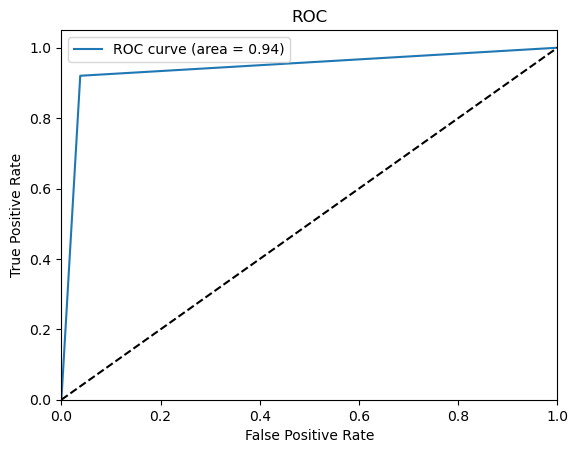

In [156]:
plot.roc(test_pred_nn, y_test)

## SHAP Explainability

In [160]:
# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Basic%20SHAP%20Interaction%20Value%20Example%20in%20XGBoost.html
preds = clf.predict(X_test)
exp = shap.TreeExplainer(clf)
shap_values = exp.shap_values(X_test)

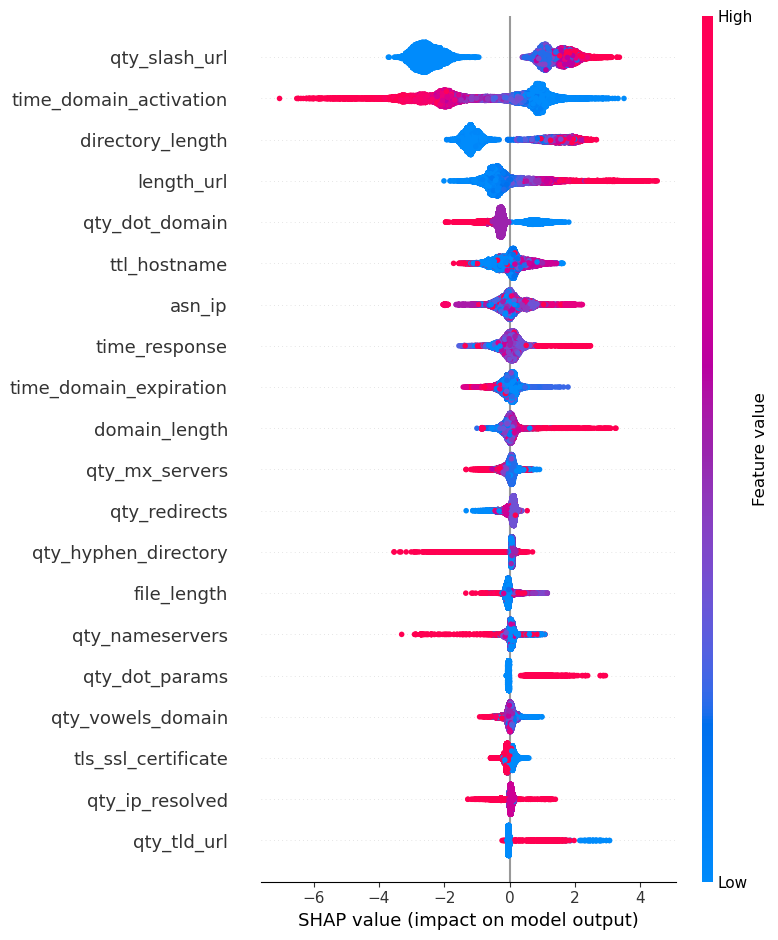

In [161]:
shap.summary_plot(shap_values, X_test)

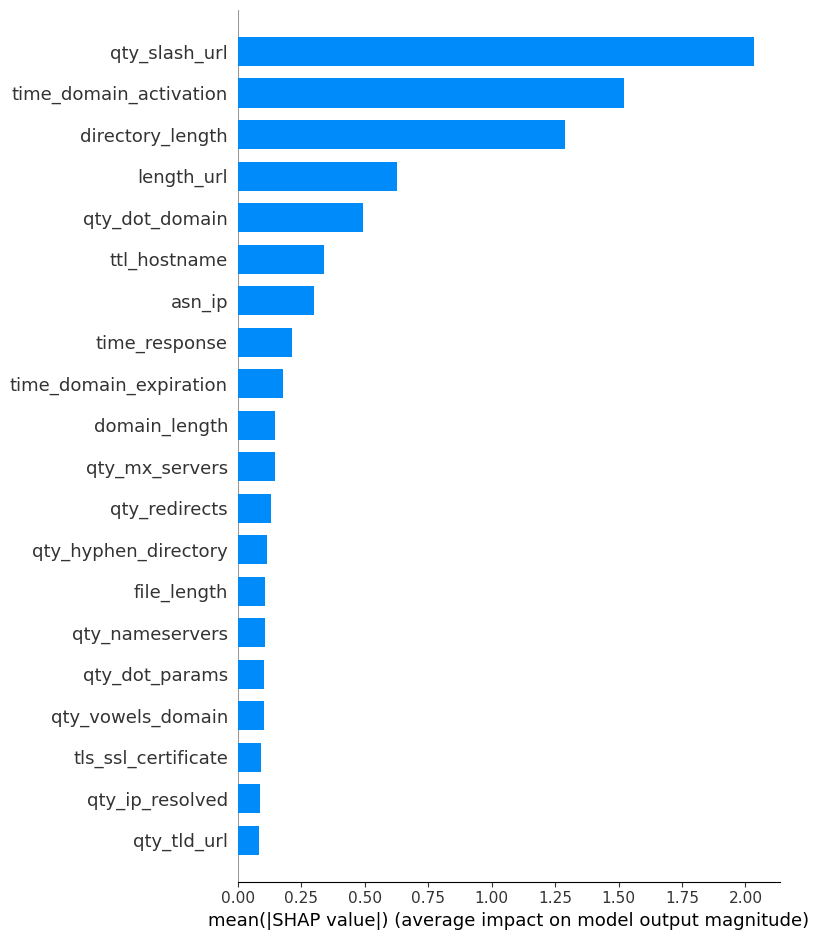

In [162]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [163]:
shap.initjs()

In [164]:
shap.force_plot(exp.expected_value, shap_values[2,:], X_test.iloc[2,:])